Data Description:
The dataset consists of the following columns:

1. sample_id: A unique identifier for the input sample
2. catalog_content: Text field containing title, product description and an Item Pack Quantity(IPQ) concatenated.
3. image_link: Public URL where the product image is available for download. Example link - https://m.media-amazon.com/images/I/71XfHPR36-L.jpg (https://m.media-amazon.com/images/I/71XfHPR36-L.jpg) To download images, use the download_images function from src/utils.py. See sample code in src/test.ipynb.
4. price: Price of the product (Target variable - only available in training data)

Dataset Details:
Training Dataset: 75k products with complete product details and prices
Test Set: 75k products for final evaluation

Output Format:
The output file should be a CSV with 2 columns:

sample_id: The unique identifier of the data sample. Note the ID should match the test record sample_id.

price: A float value representing the predicted price of the product.

Note: Make sure to output a prediction for all sample IDs. If you have less/more number of output samples in the output file as compared to test.csv, your output won't be evaluated.

File Descriptions:

Source files

1. src/utils.py: Contains helper functions for downloading images from the image_link. You may need to retry a few times to download all images due to possible throttling issues.

2. sample_code.py: Sample dummy code that can generate an output file in the given format. Usage of this file is optional.

Dataset files

dataset/train.csv: Training file with labels (price).

dataset/test.csv: Test file without output labels (price). Generate predictions using your model/solution on this file's

data and format the output file to match sample_test_out.csv

dataset/sample_test.csv: Sample test input file.

dataset/sample_test_out.csv: Sample outputs for sample_test.csv. The output for test.csv must be formatted in the

exact same way. Note: The predictions in the file might not be correct

Constraints:

You will be provided with a sample output file. Format your output to match the sample output file exactly.

Predicted prices must be positive float values.

Final model should be a MIT/Apache 2.0 License model and up to 8 Billion parameters.

Evaluation Criteria:

Submissions are evaluated using Symmetric Mean Absolute Percentage Error (SMAPE): A statistical measure that expresses the relative difference between predicted and actual values as a percentage, while treating positive and negative errors equally.

Formula:

SMAPE = (1/n) * Œ£ |predicted_price - actual_price| / ((|actual_price| + |predicted_price|)/2)
Example: If actual price = $100 and predicted price = $120
SMAPE = |100-120| / ((|100| + |120|)/2) * 100% = 18.18%

Note: SMAPE is bounded between 0% and 200%. Lower values indicate better performance.

Tips for Success:

Consider both textual features (catalog_content) and visual features (product images)
Explore feature engineering techniques for text and image data
Consider ensemble methods combining different model types
Pay attention to outliers and data preprocessing

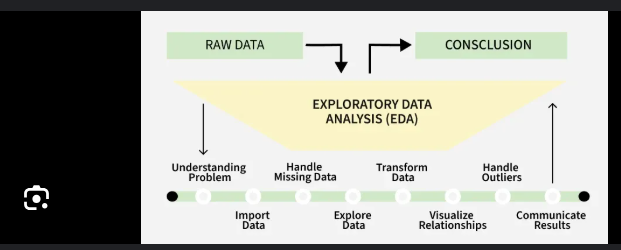

In [ ]:
# Checking out the sample data
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/student_resource/dataset/train.csv')

In [ ]:
# checking the shape of both of train
print(f"The shape of sample_test is {train.shape}")

The shape of sample_test is (75000, 4)


In [ ]:
# Checking the information
print(f"The information of sample_test is {train.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
The information of sample_test is None


In [ ]:
# Check for duplicate rows in sample_test
print(f"Number of duplicate rows in sample_test: {train.duplicated().sum()}")

# Display descriptive statistics for the 'price' column in sample_test_output
print("\nDescriptive statistics for 'price' in sample_test_output:")
display(train['price'].describe())

Number of duplicate rows in sample_test: 0

Descriptive statistics for 'price' in sample_test_output:


count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

In [ ]:
# checking for null or nan values
train.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [ ]:
# Checking for empty strings, 'unknown', or 'NA' in the DataFrame
for col in train.columns:
    print(f"Checking column: {col}")
    empty_strings = (train[col] == '').sum()
    unknown_values = (train[col] == 'unknown').sum()
    na_values = (train[col] == 'NA').sum()
    print(f"  Empty strings: {empty_strings}")
    print(f"  'unknown' values: {unknown_values}")
    print(f"  'NA' values: {na_values}")

Checking column: sample_id
  Empty strings: 0
  'unknown' values: 0
  'NA' values: 0
Checking column: catalog_content
  Empty strings: 0
  'unknown' values: 0
  'NA' values: 0
Checking column: image_link
  Empty strings: 0
  'unknown' values: 0
  'NA' values: 0
Checking column: price
  Empty strings: 0
  'unknown' values: 0
  'NA' values: 0


In [ ]:
import re

# Check for invalid URLs
def is_valid_url(url):
    # Simple regex to check for valid URL format
    regex = re.compile(
        r'^(?:http|https)://'  # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'  # domain...
        r'localhost|'  # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?'  # Optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
    return re.match(regex, url) is not None

invalid_urls = train[~train['image_link'].apply(is_valid_url)]
print(f"Number of invalid URLs: {len(invalid_urls)}")
display(invalid_urls.head())

# Check for non-HTTP(S) URLs
non_http_urls = train[~train['image_link'].str.startswith(('http://', 'https://'))]
print(f"\nNumber of non-HTTP(S) URLs: {len(non_http_urls)}")
display(non_http_urls.head())

Number of invalid URLs: 0


Empty DataFrame
Columns: [sample_id, catalog_content, image_link, price]
Index: []


Number of non-HTTP(S) URLs: 0


Empty DataFrame
Columns: [sample_id, catalog_content, image_link, price]
Index: []

In [ ]:
# Check for duplicate URLs
duplicate_urls = train[train['image_link'].duplicated(keep=False)]
# Arranging the duplicate URLS using image_link
duplicate_urls = duplicate_urls.sort_values(by='image_link')
print(f"\nNumber of duplicate URLs: {len(duplicate_urls)}")
display(duplicate_urls.head(10))


Number of duplicate URLs: 4887


sample_id                                    catalog_content  \
41894     143312  Item Name: Topps Baby Bottle Pop Candy (Pack o...   
20960     143302  Item Name: Topps Baby Bottle Pop Candy (Pack o...   
36353      39215  Item Name: IMAGINE SOUP BUTTERNUT SQUASH ORG, ...   
68509      38521  Item Name: IMAGINE SOUP BUTTERNUT SQUASH ORG, ...   
23415      38171  Item Name: IMAGINE SOUP BUTTERNUT SQUASH ORG, ...   
2419      139760  Item Name: Lehi Roller Mills, Cookie Mix, Pump...   
68024     139765  Item Name: Lehi Roller Mills, Cookie Mix, Pump...   
14052     139756  Item Name: Lehi Roller Mills, Cookie Mix, Pump...   
38069      42242  Item Name: Amy's Kitchen Golden Lentil Soup, 1...   
35181      38349  Item Name: Amy's Kitchen Golden Lentil Soup, 1...   

                                              image_link    price  
41894  https://m.media-amazon.com/images/I/11RHBkJYc2...   49.800  
20960  https://m.media-amazon.com/images/I/11RHBkJYc2...   45.700  
36353  https://m.media-amazon.com/images/I/11ddBQDd70...    4.975  
68509  https://m.media-amazon.com/images/I/11ddBQDd70...    4.975  
23415  https://m.media-amazon.com/images/I/11ddBQDd70...    4.835  
2419   https://m.media-amazon.com/images/I/21-4sRJZfj...   81.260  
68024  https://m.media-amazon.com/images/I/21-4sRJZfj...   93.170  
14052  https://m.media-amazon.com/images/I/21-4sRJZfj...  158.870  
38069  https://m.media-amazon.com/images/I/21-rPJmk0G...    5.990  
35181  https://m.media-amazon.com/images/I/21-rPJmk0G...    5.990

In [ ]:
image_link_count = duplicate_urls.value_counts()
print(image_link_count)

sample_id  catalog_content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# duplicate_catalog_content
duplicate_catalog_content = train[train['catalog_content'].duplicated(keep=False)]
duplicate_catalog_content = duplicate_catalog_content.sort_values(by='catalog_content')
print(f"\nNumber of duplicate catalog_content: {len(duplicate_catalog_content)}")
display(duplicate_catalog_content.head(10))


Number of duplicate catalog_content: 193


sample_id                                    catalog_content  \
9893       39527  Item Name: 100% Organic Tahini\nValue: 144.0\n...   
50721      38141  Item Name: 100% Organic Tahini\nValue: 144.0\n...   
16128     227464  Item Name: 12 Pack: FolkArt¬Æ Glossy‚Ñ¢ High-Glos...   
49152     227460  Item Name: 12 Pack: FolkArt¬Æ Glossy‚Ñ¢ High-Glos...   
64462      48614  Item Name: ABSOLUTELY GLUTEN FREE FLATBREAD GF...   
47416      48844  Item Name: ABSOLUTELY GLUTEN FREE FLATBREAD GF...   
63885     188458  Item Name: AmazonFresh Hazelnut Flavored Coffe...   
11795     185463  Item Name: AmazonFresh Hazelnut Flavored Coffe...   
52905     203590  Item Name: Amos Gummi Teeth Candy Vampire Teet...   
23844     214546  Item Name: Amos Gummi Teeth Candy Vampire Teet...   

                                              image_link  price  
9893   https://m.media-amazon.com/images/I/31FgowO7n2...  96.36  
50721  https://m.media-amazon.com/images/I/41Gbz+dXLq...  96.36  
16128  https://m.media-amazon.com/images/I/31W8vgb7iW...  40.24  
49152  https://m.media-amazon.com/images/I/31ztOK6Qrl...  40.24  
64462  https://m.media-amazon.com/images/I/61UU3-HsuM...  72.41  
47416  https://m.media-amazon.com/images/I/61UU3-HsuM...  72.41  
63885  https://m.media-amazon.com/images/I/81w29mbZOt...   7.64  
11795  https://m.media-amazon.com/images/I/81w29mbZOt...   7.29  
52905  https://m.media-amazon.com/images/I/71+uhHl+kw...   9.99  
23844  https://m.media-amazon.com/images/I/71xXcV-ilH...   9.99

In [ ]:
# Check if "price" is mentioned in catalog_content
price_in_catalog = train[train['catalog_content'].str.contains('Unit price', case=False, na=False)]

# Print the sample_ids
print("Sample IDs where 'Unit price' is mentioned in catalog_content:")
print(price_in_catalog['sample_id'].to_list())

# Print the total count
print(f"\nTotal count of rows where 'Unit price' is mentioned in catalog_content: {len(price_in_catalog)}")

# Display the rows
print("\nSample IDs with 'Unit price' mentioned in catalog_content:")
display(price_in_catalog.head(5))

Sample IDs where 'Unit price' is mentioned in catalog_content:
[81259, 48298, 156151, 298340, 294896, 98192, 163816, 294932, 160452, 98191, 168897, 171670, 255103, 41563, 252024, 169390, 253821, 257558, 255359, 158773, 41580, 27381, 167043, 98589, 224557, 168837, 171381, 29186, 298334, 159831, 81204, 162561, 81384, 98195, 192221, 297357, 168362, 294794, 173214, 32164, 98591, 298380, 127154, 168396, 255805, 277789, 199761, 255396, 161164, 41558, 294083, 81312, 126684, 294761, 253657, 254128, 41584, 41526, 35192, 158775, 81343, 85382, 252016, 98201, 172658, 98640, 252021, 298290, 81620, 173479, 298302, 35765, 256419, 184984, 173771, 168403, 257495, 252008, 252005, 254633, 298350, 256723, 98585, 37127, 41553, 98587, 153527]

Total count of rows where 'Unit price' is mentioned in catalog_content: 87

Sample IDs with 'Unit price' mentioned in catalog_content:


sample_id                                    catalog_content  \
94        81259  Item Name: Chex Gluten Free Rice Chex Cereal, ...   
624       48298  Item Name: Starbucks Classic Hot Cocoa (Toaste...   
3485     156151  Item Name: Kashi Organic Promise Cereal, Berry...   
5759     298340  Item Name: Kraft Spoonable Sandwich Spread, 15...   
6229     294896  Item Name: Minute Ready to Serve Brown & Wild ...   

                                             image_link   price  
94    https://m.media-amazon.com/images/I/817-8iLd0U...   5.490  
624   https://m.media-amazon.com/images/I/61ogrvI98W...   7.995  
3485  https://m.media-amazon.com/images/I/71w2dB1CqY...  10.020  
5759  https://m.media-amazon.com/images/I/51BJuOOdQy...   3.405  
6229  https://m.media-amazon.com/images/I/71uc54dl7m...   1.990

# Here we create the DF

In [ ]:
import re
# Removing the price leakage that is happening, where the price metioned in the descritpion doesn't match the price derived using the mathematical calucation
def remove_price_leakage(text):
    # Remove any price mentions
    patterns = [
        r'Unit Price of \$[0-9.]+',
        r'Price: \$?[0-9.]+',
        r'\$[0-9]+\.?[0-9]*',
        r'[0-9]+\.[0-9]+ dollars?'
    ]

    cleaned = text
    for pattern in patterns:
        cleaned = re.sub(pattern, '[PRICE_REMOVED]', cleaned, flags=re.IGNORECASE)

    return cleaned

df = train.copy() # making a copy and not referenceing the same dataframe
df['catalog_content'] = df['catalog_content'].apply(remove_price_leakage)

# Price leaking removed.

In [ ]:
# Checking if the partern is still there or not
import re

patterns = [
    r'Unit Price of \$[0-9.]+',
    r'Price: \$?[0-9.]+',
    r'\$[0-9]+\.?[0-9]*',
    r'[0-9]+\.[0-9]+ dollars?'
]

# Function to find price patterns in the text
def find_patterns(text, patterns):
    found_patterns = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            found_patterns.extend(matches)
    return list(set(found_patterns))

# Create a new DataFrame with rows where price patterns are found
price_pattern_df = df[df['catalog_content'].apply(lambda x: len(find_patterns(x, patterns)) > 0)]

# Display the number of rows and the first few rows of the new DataFrame
print(f"\nNumber of rows where price patterns were found after removing leakage: {len(price_pattern_df)}")
display(price_pattern_df.head())


Number of rows where price patterns were found after removing leakage: 0


Empty DataFrame
Columns: [sample_id, catalog_content, image_link, price]
Index: []

In [ ]:
# Checking for presence of "Item Name:", "Value:", and "Unit:" in catalog_content
item_name_count = df['catalog_content'].str.contains('Item Name', na=False).sum()
value_count = df['catalog_content'].str.contains('Value:', na=False).sum()
unit_count = df['catalog_content'].str.contains('Unit:', na=False).sum()

print(f"Count of the following important details in Train Data")
print(f"Number of rows with 'Item Name:': {item_name_count}")
print(f"Number of rows with 'Value:': {value_count}")
print(f"Number of rows with 'Unit:': {unit_count}")

# Checking the same in test data
test = pd.read_csv('/content/drive/MyDrive/student_resource/dataset/test.csv')
item_name_count_test = test['catalog_content'].str.contains('Item Name', na=False).sum()
value_count_test = test['catalog_content'].str.contains('Value:', na=False).sum()
unit_count_test = test['catalog_content'].str.contains('Unit:', na=False).sum()

print(f"\nCount of the following important details in Test Data")
print(f"Number of rows with 'Item Name:': {item_name_count_test}")
print(f"Number of rows with 'Value:': {value_count_test}")
print(f"Number of rows with 'Unit:': {unit_count_test}")

Count of the following important details in Train Data
Number of rows with 'Item Name:': 75000
Number of rows with 'Value:': 75000
Number of rows with 'Unit:': 75000

Count of the following important details in Test Data
Number of rows with 'Item Name:': 75000
Number of rows with 'Value:': 75000
Number of rows with 'Unit:': 75000


# Both train and test all of them have iteam name, value, and unit and hence they can have sepreate columns for the same

In [ ]:
import pandas as pd
import re

valid_units = [
    'fl oz', 'oz', 'ounce', 'ounces', 'fluid ounce', 'fluid ounces',
    'gram', 'grams', 'gr', 'kg', 'lb', 'pound', 'pounds',
    'ml', 'millilitre', 'milliliter', 'ltr', 'liter', 'liters',
    'count', 'ct', 'each', 'piece', 'unit', 'can', 'jar', 'bag',
    'sq ft', 'in', 'cm', 'foot'
]

ignored_units = set([
    '', 'none', 'None', 'other', 'bottle', 'bottles', 'case', 'pack', 'packs', 'tea bags',
    'comes as single', 'box', 'per package', 'per box', 'per carton', 'product', 'paper cupcake liners', 'comes as a single', 'ziplock bags', 'ziplock bag',
    'tea bags', 'bucket', 'per carton',
    'k', 'k-cups', 'kcups', 'k cup', 'k-cup', 'k cup pack', 'k-cups pack',
    'carton', 'pouch', 'jar', 'can' , 'bag', 'bags'

])

unit_map = {
    'fl oz': 'fl oz', 'fluid ounce': 'fl oz', 'fluid ounces': 'fl oz', 'fl': 'fl oz', 'fl ounce' : 'fl oz',
    'oz': 'oz', 'ounce': 'oz', 'ounces': 'oz',
    'gram': 'g', 'grams': 'g', 'gr': 'g', 'gramm': 'g',
    'kg': 'kg', 'lb': 'lb', 'pound': 'lb', 'pounds': 'lb',
    'ml': 'ml', 'millilitre': 'ml', 'milliliter': 'ml', 'mililitro': 'ml',
    'ltr': 'l', 'liters': 'l', 'liter': 'l',
    'ct': 'count', 'count': 'count', 'each': 'count', 'piece': 'count',
    'in': 'in', 'cm': 'cm', 'sq ft': 'sq ft', 'foot': 'ft',
    'capsule': 'count', 'capsules': 'count',
    'k': 'count', 'k-cups': 'count', 'kcups': 'count', 'k cup': 'count', 'k-cup': 'count', 'k cup pack': 'count', 'k-cups pack': 'count',
    'unit': 'unit', 'units': 'unit'
}

# Normalize unit names=
def normalize_unit(raw_unit):
    unit = raw_unit.strip().lower()
    return unit_map.get(unit, unit) if unit not in ignored_units else None

def extract_fields(text):
    itemname_match = re.search(r"Item Name:\s*(.*)", text)
    value_match = re.search(r"Value:\s*([\d.]+)", text)
    unit_match = re.search(r"Unit:\s*([A-Za-z ]+)", text)

    itemname = itemname_match.group(1).strip() if itemname_match else None
    value = float(value_match.group(1)) if value_match else None
    unit = normalize_unit(unit_match.group(1)) if unit_match else None

    # Fallback: if value or unit is missing, or unit is ignored
    if not value or not unit or unit in ignored_units:
        pattern = r"(\d+(?:\.\d+)?)\s*([A-Za-z]+(?: [A-Za-z]+)?)"
        matches = re.findall(pattern, text)

        for val, raw_unit in matches:
            norm_unit = normalize_unit(raw_unit)  # Only proceed if it's mappable (even if not valid)
            if norm_unit in valid_units:
                value = float(val)
                unit = norm_unit
                break  # Stop at first good match

    # Final defaults
    if value is None:
        value = 1
    if unit is None or unit in ignored_units:
        unit = "count"

    return pd.Series({
        "itemname": itemname,
        "value": value,
        "unit": unit
    })


# Apply to catalog_content column
df_extracted = df['catalog_content'].apply(extract_fields)
df = pd.concat([df, df_extracted], axis=1)

In [ ]:
# Rounding the price to the 4th decimal
df['price'] = df['price'].round(4)

In [ ]:
df.head(5)

sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee‚Äôs Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  \
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89   
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12   
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97   
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34   
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49   

                                            itemname  value   unit  
0  La Victoria Green Taco Sauce Mild, 12 Ounce (P...  72.00  fl oz  
1  Salerno Cookies, The Original Butter Cookies, ...  32.00     oz  
2  Bear Creek Hearty Soup Bowl, Creamy Chicken wi...  11.40     oz  
3  Judee‚Äôs Blue Cheese Powder 11.25 oz - Gluten-F...  11.25     oz  
4  kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...  12.00  count

In [ ]:
# Checking the unique values in 'unit'
print(len(df['unit'].unique()))
df['unit'].unique()

13


array(['fl oz', 'oz', 'count', 'lb', 'cm', 'g', 'l', 'unit', 'ml', 'in',
       'kg', 'sq ft', 'ft'], dtype=object)

In [ ]:
# Checking the count of each unique unit
print(df['unit'].value_counts())

unit
oz       44344
count    18817
fl oz    11362
lb         285
unit        63
g           51
cm          26
ml          25
l            8
in           8
kg           8
ft           2
sq ft        1
Name: count, dtype: int64


# At this point I'm confident about Unit next checking the values


In [ ]:
# Checking for null, none, or nan values or 0 in the value column
print("The null values in the 'value' column are: ", df['value'].isnull().sum())
print("The number of na value in the 'value' column are: ", df['value'].isna().sum())


The null values in the 'value' column are:  0
The number of na value in the 'value' column are:  0


In [ ]:
# And the summary mean, median, range, average, etc of the value
print(df['value'].describe())

count    75000.000000
mean        53.796737
std        458.992965
min          0.000000
25%          6.000000
50%         16.000000
75%         48.000000
max      63882.000000
Name: value, dtype: float64


#I have not been able to solve the problem where the volumn 'value' has 0.0 so, now I'm going to solve it here instead. Dropping them only 16

In [ ]:
# Checking all the rows with value as 0
zero_value_rows = df[df['value'] == 0]

# Dropping them
df = df[df['value'] != 0]

In [ ]:
df.shape

(74984, 7)

# Value is polished

In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'itemname' column are: ", df['itemname'].isnull().sum())
print("The number of na value in the 'itemname' column are: ", df['itemname'].isna().sum())
print("Count Rows with empty value in the 'itemname' columns are: ", len(df[df['itemname'] == '']))


The null values in the 'itemname' column are:  7
The number of na value in the 'itemname' column are:  7
Count Rows with empty value in the 'itemname' columns are:  0


In [ ]:
# Only 7 rows dropping them
df = df[df['itemname'].notnull()]
df.shape

(74977, 7)

In [ ]:
import re

def clean_item_name(name):
    # Lowercase for uniformity
    name = name.lower().strip()

    # Remove pack details or weight specs at the end in parentheses
    name = re.sub(r'\s*\(pack of \d+\)$', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\s*\(\d+(\.\d+)?\s*(oz|lbs?|g|count)\)$', '', name, flags=re.IGNORECASE)

    # Remove trailing non-alphanumeric chars
    name = re.sub(r'[^a-z0-9\s]+$', '', name)

    return name

# Apply to dataframe column
df['item_name_clean'] = df['itemname'].apply(clean_item_name)


In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'itemname' column are: ", df['item_name_clean'].isnull().sum())
print("The number of na value in the 'itemname' column are: ", df['item_name_clean'].isna().sum())
print("Count Rows with empty value in the 'itemname' columns are: ", len(df[df['item_name_clean'] == '']))


The null values in the 'itemname' column are:  0
The number of na value in the 'itemname' column are:  0
Count Rows with empty value in the 'itemname' columns are:  2


In [ ]:
print("Count Rows with empty value in the 'itemname' columns are: ", len(df[df['item_name_clean'] == '']))
df[df['item_name_clean'] == '']

# Removing the those rows
df = df[df['item_name_clean'] != '']

Count Rows with empty value in the 'itemname' columns are:  2


In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'item_name_clean' column are: ", df['item_name_clean'].isnull().sum())
print("The number of na value in the 'item_name_clean' column are: ", df['item_name_clean'].isna().sum())
print("Count Rows with empty value in the 'item_name_clean' columns are: ", len(df[df['item_name_clean'] == '']))

The null values in the 'item_name_clean' column are:  0
The number of na value in the 'item_name_clean' column are:  0
Count Rows with empty value in the 'item_name_clean' columns are:  0


# Item Name is polished now.

# Creaing the Pack_value and is_pack_column

In [ ]:
pack_rows = df[df['catalog_content'].str.contains(r'\bpack\b', case=False, na=False)]
print(f"Total rows with 'pack' keyword: {len(pack_rows)}")


Total rows with 'pack' keyword: 31767


In [ ]:
# Creating the boolean column for pack product or not
import re

def is_pack_item(catalog_content):
    """
    Checks if the catalog content indicates a pack item.
    Looks for patterns like "pack of X", "X count", "X ct", etc.
    """
    if isinstance(catalog_content, str):
        # Using regex to find patterns indicating a pack
        # This is a starting point and can be refined based on data patterns
        patterns = [
            r'pack of \d+',
            r'\d+ count',
            r'\d+ ct',
            r'\d+ pack',
            r'\d+ x ', # e.g., 6 x 10 oz
            r'\d+/', # e.g., 12/pack
            r'case of \d+'
        ]
        for pattern in patterns:
            if re.search(pattern, catalog_content, re.IGNORECASE):
                return True
    return False

# Apply the function to create the new 'is_pack_item' column
df['is_pack_item'] = df['catalog_content'].apply(is_pack_item)

# Display the count of pack items and non-pack items
print("Count of 'is_pack_item':")
print(df['is_pack_item'].value_counts())

Count of 'is_pack_item':
is_pack_item
False    40013
True     34962
Name: count, dtype: int64


In [ ]:
import re

def extract_pack_count(text):
    patterns = [
        r'Pack of (\d+)',
        r'(\d+)[-\s]*Pack',
        r'per pack[:\s]*(\d+)',
        r'Case of (\d+)',
        r'(\d+) count',
        r'(\d+) ct'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            return int(match.group(1))
    return 1  # default for single items

df['pack_count'] = df['catalog_content'].apply(extract_pack_count)

In [ ]:
# checking to see the count of row where the is_pack_item true
pack_rows = df[df['is_pack_item'] == True]
print(f"Total rows with 'pack' keyword: {len(pack_rows)}")

Total rows with 'pack' keyword: 34962


In [ ]:
# Calculate price per pack
df['price_per_pack'] = df['price'] / df['pack_count']

# If pack_count is 0 or missing (just in case), fill with 1 to avoid division errors
df['pack_count'].replace(0, 1, inplace=True)
df['price_per_pack'] = df['price'] / df['pack_count']


   price  pack_count  price_per_pack
0   4.89           6        0.815000
1  13.12           4        3.280000
2   1.97           6        0.328333
3  30.34           1       30.340000
4  66.49           1       66.490000


/tmp/ipython-input-3591844328.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pack_count'].replace(0, 1, inplace=True)


In [ ]:
# Display the first few rows with the new column
df.head(10)

sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee‚Äôs Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   
5       9259  Item Name: Member's Mark Member's Mark, Basil,...   
6     191846  Item Name: Goya Foods Sazonador Total Seasonin...   
7     222007  Item Name: VineCo Original Series Chilean Sauv...   
8      37614  Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...   
9     238044  Item Name: Mrs. Miller's Seedless Black Raspbe...   

                                          image_link  price  \
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89   
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12   
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97   
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34   
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49   
5  https://m.media-amazon.com/images/I/81nw0HXpCR...  18.50   
6  https://m.media-amazon.com/images/I/61dH2Ebkt0...   5.99   
7  https://m.media-amazon.com/images/I/71JllaFpxM...  94.00   
8  https://m.media-amazon.com/images/I/21O9RftI2v...  35.74   
9  https://m.media-amazon.com/images/I/41miQk+RkJ...  31.80   

                                            itemname   value   unit  \
0  La Victoria Green Taco Sauce Mild, 12 Ounce (P...   72.00  fl oz   
1  Salerno Cookies, The Original Butter Cookies, ...   32.00     oz   
2  Bear Creek Hearty Soup Bowl, Creamy Chicken wi...   11.40     oz   
3  Judee‚Äôs Blue Cheese Powder 11.25 oz - Gluten-F...   11.25     oz   
4  kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...   12.00  count   
5        Member's Mark Member's Mark, Basil, 6.25 oz    6.25     oz   
6  Goya Foods Sazonador Total Seasoning, 30 Ounce...  180.00     oz   
7  VineCo Original Series Chilean Sauvignon Blanc...    1.00  count   
8  NATURES PATH CEREAL FLK MULTIGRAIN ORG ECO, 32...  192.00  fl oz   
9  Mrs. Miller's Seedless Black Raspberry Jam 9 O...    9.00     oz   

                                     item_name_clean  is_pack_item  \
0        la victoria green taco sauce mild, 12 ounce          True   
1  salerno cookies, the original butter cookies, ...          True   
2  bear creek hearty soup bowl, creamy chicken wi...          True   
3  judee‚Äôs blue cheese powder 11.25 oz - gluten-f...         False   
4  kedem sherry cooking wine, 12.7 ounce - 12 per...         False   
5        member's mark member's mark, basil, 6.25 oz         False   
6     goya foods sazonador total seasoning, 30 ounce          True   
7  vineco original series chilean sauvignon blanc...         False   
8  natures path cereal flk multigrain org eco, 32...         False   
9  mrs. miller's seedless black raspberry jam 9 o...          True   

   pack_count  price_per_pack  
0           6        0.815000  
1           4        3.280000  
2           6        0.328333  
3           1       30.340000  
4           1       66.490000  
5           1       18.500000  
6           6        0.998333  
7           1       94.000000  
8           1       35.740000  
9           4        7.950000

# Here the pack, boolean check of pack, and price per pack is done


In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'catalog_content' column are: ", df['catalog_content'].isnull().sum())
print("The number of na value in the 'catalog_content' column are: ", df['catalog_content'].isna().sum())
print("Count Rows with empty value in the 'catalog_content' columns are: ", len(df[df['catalog_content'] == '']))

The null values in the 'catalog_content' column are:  0
The number of na value in the 'catalog_content' column are:  0
Count Rows with empty value in the 'catalog_content' columns are:  0


In [ ]:
import re

def clean_catalog_content(text):
    # Remove Value line
    text = re.sub(r'Value:\s*[0-9\.]+\n?', '', text, flags=re.IGNORECASE)

    # Remove Unit line
    text = re.sub(r'Unit:\s*[A-Za-z ]+\n?', '', text, flags=re.IGNORECASE)

    # Remove Pack size info in parenthesis e.g., (Pack of 12)
    text = re.sub(r'\(Pack of \d+\)', '', text, flags=re.IGNORECASE)

    # Remove price leaks placeholder, if any
    text = re.sub(r'\[PRICE_REMOVED\]', '', text)

    # Strip leading/trailing spaces and multiple newlines
    text = re.sub(r'\n+', '\n', text).strip()

    return text

# Apply cleaning to dataframe
trail_df = df.copy()
trail_df['cleaned_catalog_content'] = df['catalog_content'].apply(clean_catalog_content)

In [ ]:
trail_df.head(10)

sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee‚Äôs Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   
5       9259  Item Name: Member's Mark Member's Mark, Basil,...   
6     191846  Item Name: Goya Foods Sazonador Total Seasonin...   
7     222007  Item Name: VineCo Original Series Chilean Sauv...   
8      37614  Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...   
9     238044  Item Name: Mrs. Miller's Seedless Black Raspbe...   

                                          image_link  price  \
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89   
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12   
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97   
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34   
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49   
5  https://m.media-amazon.com/images/I/81nw0HXpCR...  18.50   
6  https://m.media-amazon.com/images/I/61dH2Ebkt0...   5.99   
7  https://m.media-amazon.com/images/I/71JllaFpxM...  94.00   
8  https://m.media-amazon.com/images/I/21O9RftI2v...  35.74   
9  https://m.media-amazon.com/images/I/41miQk+RkJ...  31.80   

                                            itemname   value   unit  \
0  La Victoria Green Taco Sauce Mild, 12 Ounce (P...   72.00  fl oz   
1  Salerno Cookies, The Original Butter Cookies, ...   32.00     oz   
2  Bear Creek Hearty Soup Bowl, Creamy Chicken wi...   11.40     oz   
3  Judee‚Äôs Blue Cheese Powder 11.25 oz - Gluten-F...   11.25     oz   
4  kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...   12.00  count   
5        Member's Mark Member's Mark, Basil, 6.25 oz    6.25     oz   
6  Goya Foods Sazonador Total Seasoning, 30 Ounce...  180.00     oz   
7  VineCo Original Series Chilean Sauvignon Blanc...    1.00  count   
8  NATURES PATH CEREAL FLK MULTIGRAIN ORG ECO, 32...  192.00  fl oz   
9  Mrs. Miller's Seedless Black Raspberry Jam 9 O...    9.00     oz   

                                     item_name_clean  is_pack_item  \
0        la victoria green taco sauce mild, 12 ounce          True   
1  salerno cookies, the original butter cookies, ...          True   
2  bear creek hearty soup bowl, creamy chicken wi...          True   
3  judee‚Äôs blue cheese powder 11.25 oz - gluten-f...         False   
4  kedem sherry cooking wine, 12.7 ounce - 12 per...         False   
5        member's mark member's mark, basil, 6.25 oz         False   
6     goya foods sazonador total seasoning, 30 ounce          True   
7  vineco original series chilean sauvignon blanc...         False   
8  natures path cereal flk multigrain org eco, 32...         False   
9  mrs. miller's seedless black raspberry jam 9 o...          True   

   pack_count  price_per_pack  \
0           6        0.815000   
1           4        3.280000   
2           6        0.328333   
3           1       30.340000   
4           1       66.490000   
5           1       18.500000   
6           6        0.998333   
7           1       94.000000   
8           1       35.740000   
9           4        7.950000   

                             cleaned_catalog_content  
0  Item Name: La Victoria Green Taco Sauce Mild, ...  
1  Item Name: Salerno Cookies, The Original Butte...  
2  Item Name: Bear Creek Hearty Soup Bowl, Creamy...  
3  Item Name: Judee‚Äôs Blue Cheese Powder 11.25 oz...  
4  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...  
5  Item Name: Member's Mark Member's Mark, Basil,...  
6  Item Name: Goya Foods Sazonador Total Seasonin...  
7  Item Name: VineCo Original Series Chilean Sauv...  
8  Item Name: NATURES PATH CEREAL FLK MULTIGRAIN ...  
9  Item Name: Mrs. Miller's Seedless Black Raspbe...

In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'cleaned_catalog_content' column are: ", trail_df['cleaned_catalog_content'].isnull().sum())
print("The number of na value in the 'cleaned_catalog_content' column are: ", trail_df['cleaned_catalog_content'].isna().sum())
print("Count Rows with empty value in the 'cleaned_catalog_content' columns are: ", len(trail_df[trail_df['cleaned_catalog_content'] == '']))

The null values in the 'cleaned_catalog_content' column are:  0
The number of na value in the 'cleaned_catalog_content' column are:  0
Count Rows with empty value in the 'cleaned_catalog_content' columns are:  0


In [ ]:
# Adding the cleaned_catalog_content column to df
df['cleaned_catalog_content'] = trail_df['cleaned_catalog_content']

In [ ]:
import pandas as pd

# 1. Check for nulls in critical columns
def check_nulls(df):
    print("Null values in key columns:")
    for col in ['itemname', 'value', 'unit', 'item_name_clean', 'is_pack_item', 'pack_count', 'price_per_pack', 'cleaned_catalog_content']:
        print(f"{col}: {df[col].isnull().sum()}")

# 2. Check for duplicate sample_ids
def check_duplicates(df):
    dup_count = df['sample_id'].duplicated().sum()
    print(f"Duplicate sample_id count: {dup_count}")

# 3. Verify unit standardization coverage
def check_unit_coverage(df):
    print("Unique units found and their counts:")
    print(df['unit'].value_counts())

# 4. Verify value distribution stats
def value_distribution(df):
    print("Value statistics:")
    print(df['value'].describe())
    zero_vals = (df['value'] == 0).sum()
    print(f"Rows with value=0: {zero_vals}")

# 5. Inspect pack count distribution
def pack_count_distribution(df):
    print("Pack count value counts:")
    print(df['pack_count'].value_counts())

# 6. Check price_per_pack calculation
def check_price_per_pack(df):
    miscalc = df[df['price_per_pack'] != df['price'] / df['pack_count']]
    print(f"Rows with mismatched price_per_pack calculation: {len(miscalc)}")

# 7. Check text cleaning sanity
def check_text_cleaning(df):
    empty_rows = (df['cleaned_catalog_content'].str.strip() == '').sum()
    print(f"Rows with empty cleaned_catalog_content: {empty_rows}")

# Run the checks
def final_data_check(df):
    print("=== Final Data Integrity Check ===")
    check_nulls(df)
    check_duplicates(df)
    check_unit_coverage(df)
    value_distribution(df)
    pack_count_distribution(df)
    check_price_per_pack(df)
    check_text_cleaning(df)
    print("==================================")

# Usage on your current dataframe 'df'
final_data_check(df)


=== Final Data Integrity Check ===
Null values in key columns:
itemname: 0
value: 0
unit: 0
item_name_clean: 0
is_pack_item: 0
pack_count: 0
price_per_pack: 0
cleaned_catalog_content: 0
Duplicate sample_id count: 0
Unique units found and their counts:
unit
oz       44341
count    18812
fl oz    11362
lb         285
g           51
unit        46
cm          26
ml          25
l            8
in           8
kg           8
ft           2
sq ft        1
Name: count, dtype: int64
Value statistics:
count    74975.000000
mean        53.813361
std        459.068521
min          0.003500
25%          6.000000
50%         16.000000
75%         48.000000
max      63882.000000
Name: value, dtype: float64
Rows with value=0: 0
Pack count value counts:
pack_count
1      44188
6       5696
12      5421
2       4519
3       3919
       ...  
380        1
105        1
68         1
95         1
115        1
Name: count, Length: 151, dtype: int64
Rows with mismatched price_per_pack calculation: 0
Rows with 

In [ ]:
# Summary of value and price_per_unit
print(df[['value', 'price_per_pack']].describe())

              value  price_per_pack
count  74975.000000    7.497500e+04
mean      53.813361    1.530574e+01
std      459.068521    2.930184e+01
min        0.003500    1.348530e-10
25%        6.000000    2.499167e+00
50%       16.000000    7.590000e+00
75%       48.000000    1.761000e+01
max    63882.000000    2.796000e+03


# Textual and Numerical data done

In [ ]:
df

sample_id                                    catalog_content  \
0          33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1         198967  Item Name: Salerno Cookies, The Original Butte...   
2         261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3          55858  Item Name: Judee‚Äôs Blue Cheese Powder 11.25 oz...   
4         292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   
...          ...                                                ...   
74995      41424  Item Name: ICE BREAKERS Spearmint Sugar Free M...   
74996      35537  Item Name: Davidson's Organics, Vanilla Essenc...   
74997     249971  Item Name: Jolly Rancher Hard Candy - Blue Ras...   
74998     188322  Item Name: Nescafe Dolce Gusto Capsules - CARA...   
74999     298504  Item Name: Pimenton de la Vera - Picante (2.47...   

                                              image_link   price  \
0      https://m.media-amazon.com/images/I/51mo8htwTH...   4.890   
1      https://m.media-amazon.com/images/I/71YtriIHAA...  13.120   
2      https://m.media-amazon.com/images/I/51+PFEe-w-...   1.970   
3      https://m.media-amazon.com/images/I/41mu0HAToD...  30.340   
4      https://m.media-amazon.com/images/I/41sA037+Qv...  66.490   
...                                                  ...     ...   
74995  https://m.media-amazon.com/images/I/81p9PcPsff...  10.395   
74996  https://m.media-amazon.com/images/I/51DDKoa+mb...  35.920   
74997  https://m.media-amazon.com/images/I/91R2XCcpUf...  50.330   
74998  https://m.media-amazon.com/images/I/51W40YU98+...  15.275   
74999  https://m.media-amazon.com/images/I/81dFnrP6C4...  28.240   

                                                itemname   value   unit  \
0      La Victoria Green Taco Sauce Mild, 12 Ounce (P...   72.00  fl oz   
1      Salerno Cookies, The Original Butter Cookies, ...   32.00     oz   
2      Bear Creek Hearty Soup Bowl, Creamy Chicken wi...   11.40     oz   
3      Judee‚Äôs Blue Cheese Powder 11.25 oz - Gluten-F...   11.25     oz   
4      kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...   12.00  count   
...                                                  ...     ...    ...   
74995  ICE BREAKERS Spearmint Sugar Free Mints Tins, ...   12.00     oz   
74996  Davidson's Organics, Vanilla Essence, 100-coun...  100.00  count   
74997  Jolly Rancher Hard Candy - Blue Raspberry - 5 ...   80.00     oz   
74998  Nescafe Dolce Gusto Capsules - CARAMEL MACCHIA...   16.00  count   
74999         Pimenton de la Vera - Picante (2.47 ounce)    2.47     oz   

                                         item_name_clean  is_pack_item  \
0            la victoria green taco sauce mild, 12 ounce          True   
1      salerno cookies, the original butter cookies, ...          True   
2      bear creek hearty soup bowl, creamy chicken wi...          True   
3      judee‚Äôs blue cheese powder 11.25 oz - gluten-f...         False   
4      kedem sherry cooking wine, 12.7 ounce - 12 per...         False   
...                                                  ...           ...   
74995  ice breakers spearmint sugar free mints tins, ...          True   
74996  davidson's organics, vanilla essence, 100-coun...         False   
74997  jolly rancher hard candy - blue raspberry - 5 ...         False   
74998  nescafe dolce gusto capsules - caramel macchia...         False   
74999          pimenton de la vera - picante (2.47 ounce         False   

       pack_count  price_per_pack  \
0               6        0.815000   
1               4        3.280000   
2               6        0.328333   
3               1       30.340000   
4               1       66.490000   
...           ...             ...   
74995           8        1.299375   
74996           1       35.920000   
74997           1       50.330000   
74998           1       15.275000   
74999           1       28.240000   

                                 cleaned_catalog_content  
0      Item Name: La Victoria Green T

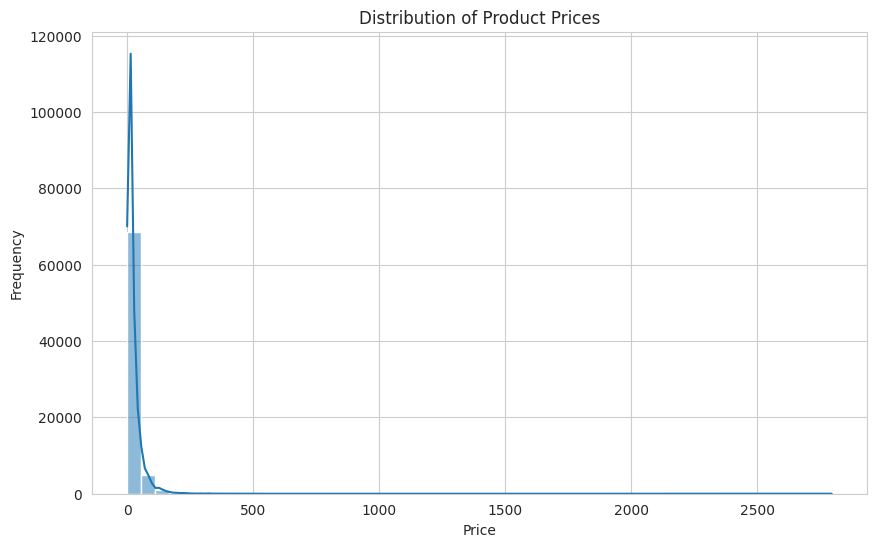

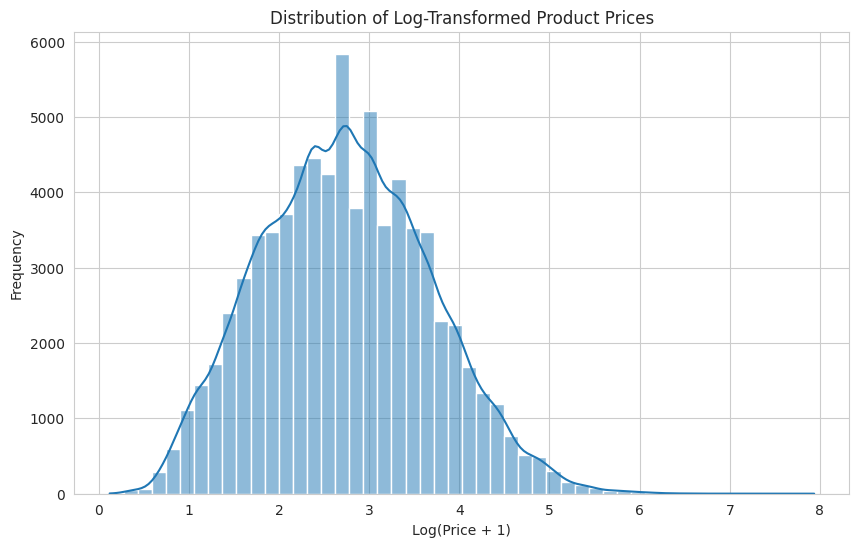

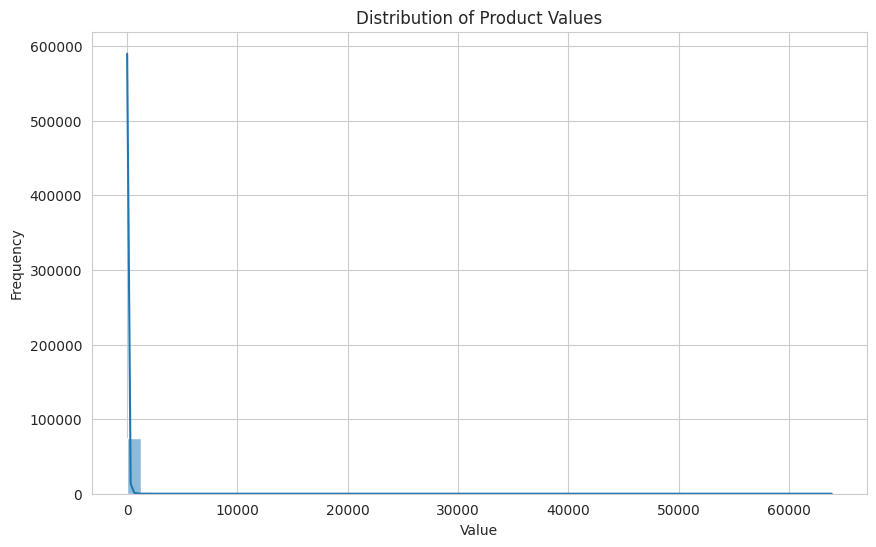

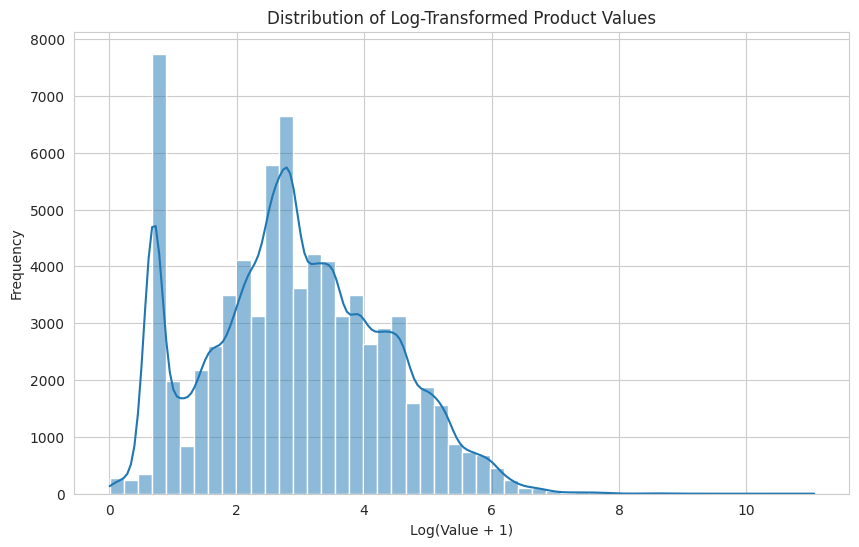

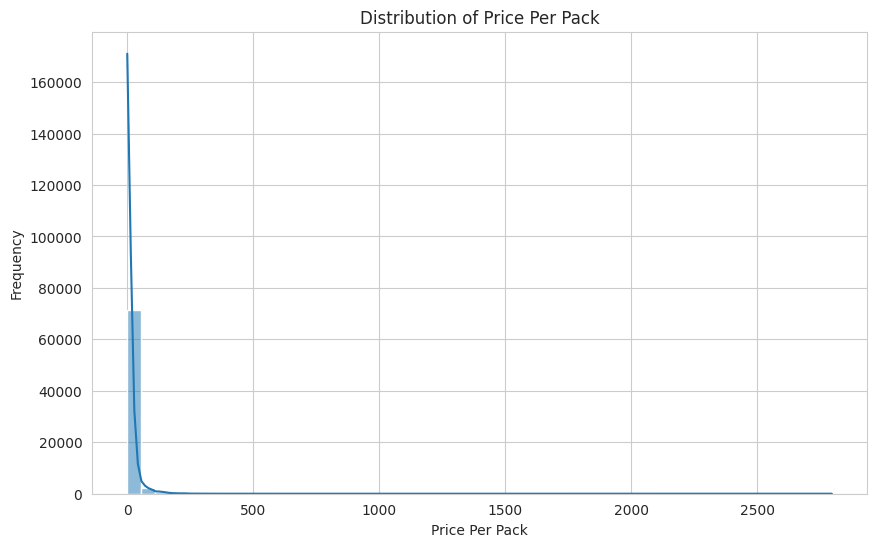

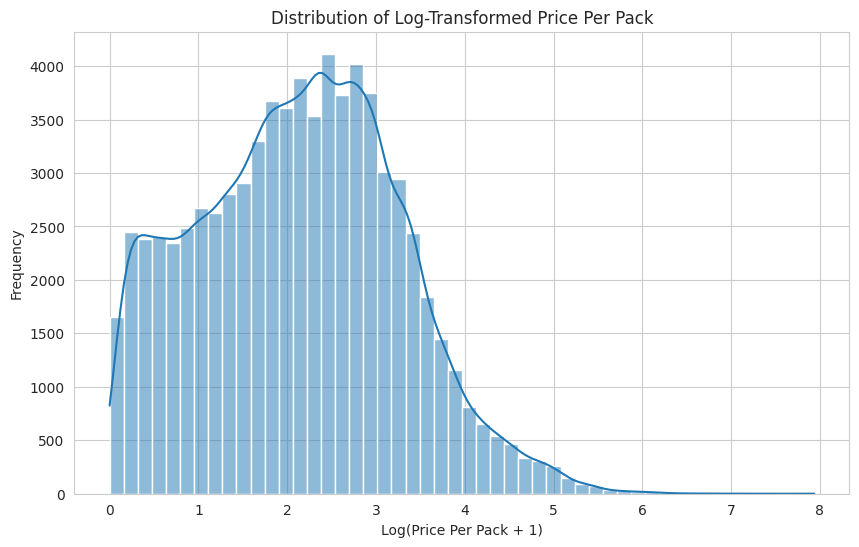

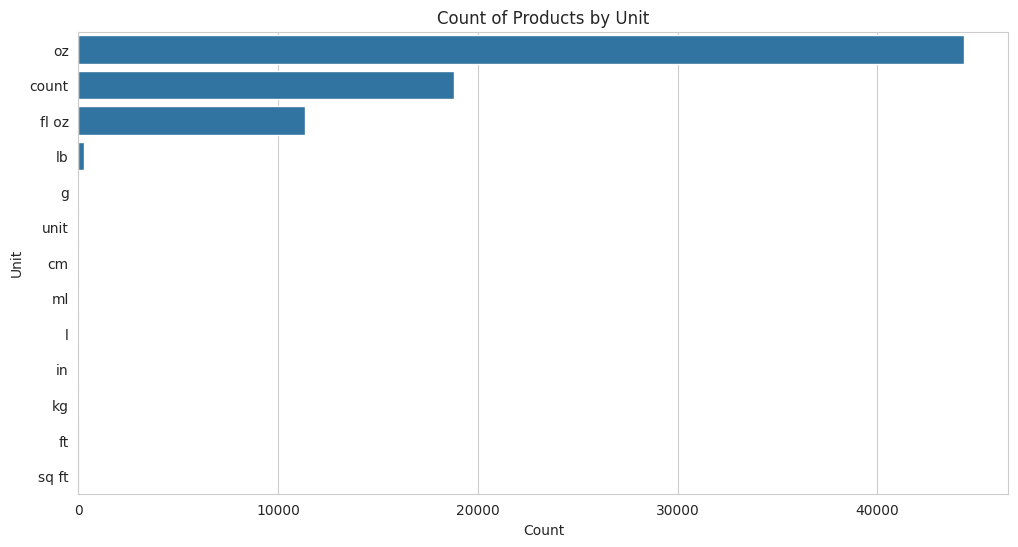

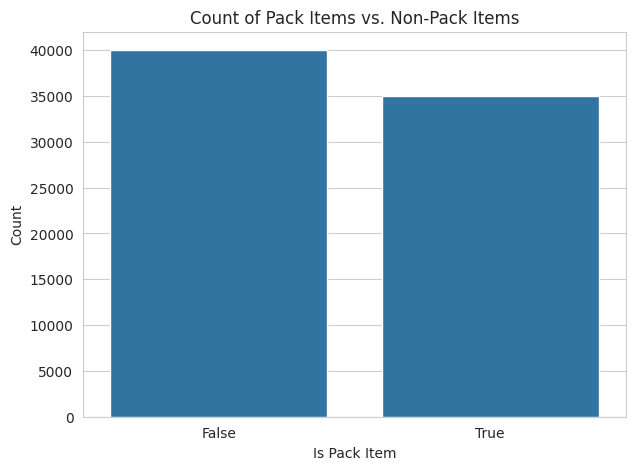

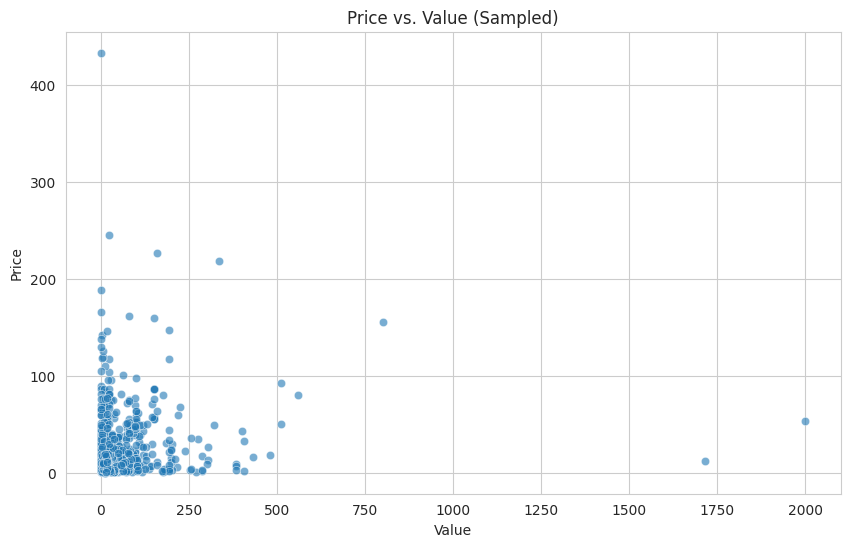

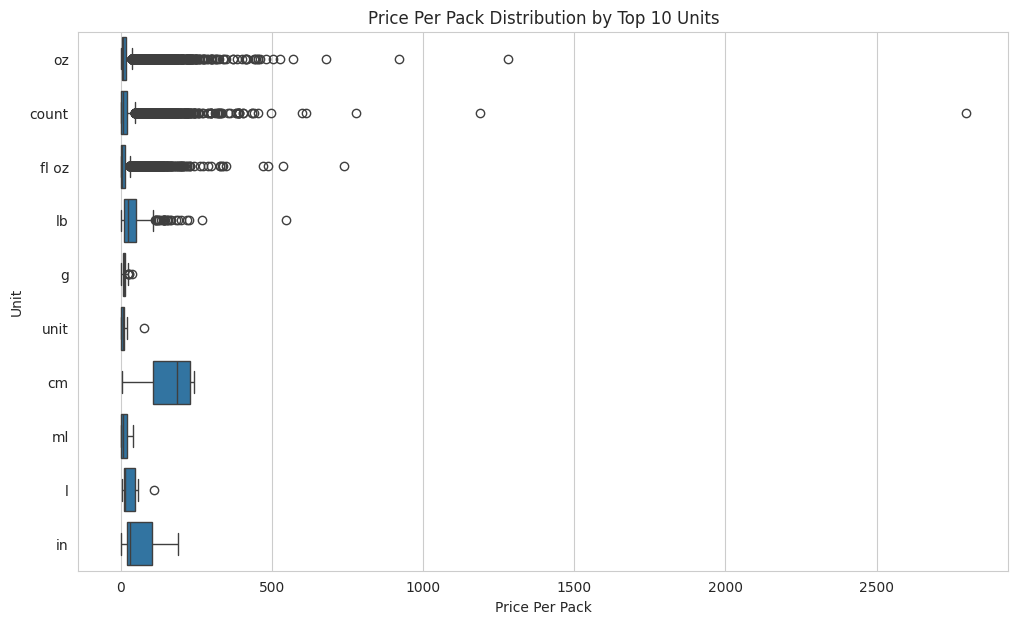

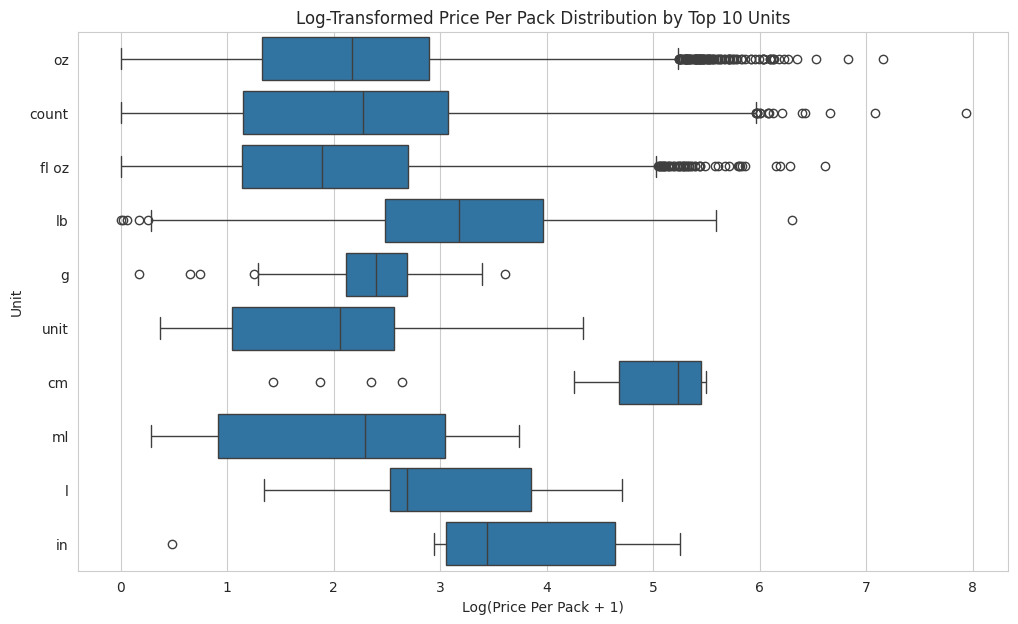

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

# Set style for plots
sns.set_style("whitegrid")

# 1. Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('price_distribution.png') # Save the plot
plt.show()

# Log-transformed distribution of Price (to handle skewness)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title('Distribution of Log-Transformed Product Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.savefig('log_price_distribution.png') # Save the plot
plt.show()


# 2. Distribution of Value
plt.figure(figsize=(10, 6))
sns.histplot(df['value'], bins=50, kde=True)
plt.title('Distribution of Product Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.savefig('value_distribution.png') # Save the plot
plt.show()

# Log-transformed distribution of Value (to handle skewness)
plt.figure(figsize=(10, 6))
sns.histplot(df['value'].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title('Distribution of Log-Transformed Product Values')
plt.xlabel('Log(Value + 1)')
plt.ylabel('Frequency')
plt.savefig('log_value_distribution.png') # Save the plot
plt.show()


# 3. Distribution of Price Per Pack
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_pack'], bins=50, kde=True)
plt.title('Distribution of Price Per Pack')
plt.xlabel('Price Per Pack')
plt.ylabel('Frequency')
plt.savefig('price_per_pack_distribution.png') # Save the plot
plt.show()

# Log-transformed distribution of Price Per Pack (to handle skewness)
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_pack'].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title('Distribution of Log-Transformed Price Per Pack')
plt.xlabel('Log(Price Per Pack + 1)')
plt.ylabel('Frequency')
plt.savefig('log_price_per_pack_distribution.png') # Save the plot
plt.show()


# 4. Count of Units
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='unit', order=df['unit'].value_counts().index)
plt.title('Count of Products by Unit')
plt.xlabel('Count')
plt.ylabel('Unit')
plt.savefig('unit_counts.png') # Save the plot
plt.show()


# 5. Count of Pack Items vs. Non-Pack Items
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='is_pack_item')
plt.title('Count of Pack Items vs. Non-Pack Items')
plt.xlabel('Is Pack Item')
plt.ylabel('Count')
plt.xticks([0, 1], ['False', 'True'])
plt.savefig('pack_item_counts.png') # Save the plot
plt.show()

# 6. Price vs. Value (Scatter plot - maybe sample a subset if too large)
# Limiting to a sample to avoid plotting too many points
sample_df = df.sample(min(1000, len(df)), random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='value', y='price', alpha=0.6)
plt.title('Price vs. Value (Sampled)')
plt.xlabel('Value')
plt.ylabel('Price')
plt.savefig('price_vs_value_scatterplot.png') # Save the plot
plt.show()

# 7. Price Per Pack vs. Unit (Box plot or Violin plot for top N units)
top_units = df['unit'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 7))
sns.boxplot(data=df[df['unit'].isin(top_units)], x='price_per_pack', y='unit', order=top_units)
plt.title('Price Per Pack Distribution by Top 10 Units')
plt.xlabel('Price Per Pack')
plt.ylabel('Unit')
plt.savefig('price_per_pack_by_unit_boxplot.png') # Save the plot
plt.show()

# Log-transformed Price Per Pack vs. Unit
plt.figure(figsize=(12, 7))
sns.boxplot(data=df[df['unit'].isin(top_units)], x=df[df['unit'].isin(top_units)]['price_per_pack'].apply(lambda x: np.log1p(x)), y='unit', order=top_units)
plt.title('Log-Transformed Price Per Pack Distribution by Top 10 Units')
plt.xlabel('Log(Price Per Pack + 1)')
plt.ylabel('Unit')
plt.savefig('log_price_per_pack_by_unit_boxplot.png') # Save the plot
plt.show()

# Starting with the Text Vectoration and Before that TF-IDF

In [ ]:
df.columns

Index(['sample_id', 'catalog_content', 'image_link', 'price', 'itemname',
       'value', 'unit', 'item_name_clean', 'is_pack_item', 'pack_count',
       'price_per_pack', 'cleaned_catalog_content'],
      dtype='object')

In [ ]:
import time
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


# Now training a XGBoost Model for the same - now this run

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# -----------------------------------
# üïí Helper function to time steps
# -----------------------------------
def timed_step(name, func, *args, **kwargs):
    print(f"\n‚û°Ô∏è Starting: {name}")
    start = time.time()
    result = func(*args, **kwargs)
    duration = time.time() - start
    print(f"‚úÖ Finished: {name} in {duration:.2f} seconds")
    return result

# -----------------------------------
# üéØ Target and Feature Setup
# -----------------------------------
print("üîß Preparing target and features...")
y = np.log1p(df['price'])

data_cols = ['value', 'pack_count', 'is_pack_item', 'unit', 'item_name_clean', 'cleaned_catalog_content']
X = df[data_cols]

# -----------------------------------
# üß± Preprocessing Pipeline
# -----------------------------------
print("üß± Setting up preprocessing pipeline...")

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['value', 'pack_count', 'is_pack_item']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['unit']),
    ('title', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_features=50000)),
        ('svd', TruncatedSVD(n_components=256, random_state=42))
    ]), 'item_name_clean'),
    ('desc', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_features=100000)),
        ('svd', TruncatedSVD(n_components=256, random_state=42))
    ]), 'cleaned_catalog_content'),
])

# -----------------------------------
# üì§ Train/Test Split
# -----------------------------------
print("üì§ Splitting data into train/test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------
# üöÇ XGBoost Model Pipeline
# -----------------------------------
model = Pipeline([
    ('pre', preprocessor),
    ('reg', XGBRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=1,
        tree_method='hist',  # 'gpu_hist' if using GPU
    ))
])

# -----------------------------------
# üèãÔ∏è Fit Model with Logging
# -----------------------------------
model = timed_step("Model Fitting (Preprocessing + XGBoost Training)", model.fit, X_train, y_train)

# -----------------------------------
# üîÆ Predictions + Inverse log
# -----------------------------------
print("üîÆ Making predictions...")
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# -----------------------------------
# üìä Evaluation
# -----------------------------------
def smape(y_true, y_pred):
    epsilon = 1e-10
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))

def mape(y_true, y_pred):
    epsilon = 1e-10
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))

print("\nüìà Evaluation Metrics:")
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
smape_score = smape(y_true, y_pred)
mape_score = mape(y_true, y_pred)

print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"R¬≤:     {r2:.4f}")
print(f"SMAPE: {smape_score:.2f}%")
print(f"MAPE:  {mape_score:.2f}%")


üîß Preparing target and features...
üß± Setting up preprocessing pipeline...
üì§ Splitting data into train/test...

‚û°Ô∏è Starting: Model Fitting (Preprocessing + XGBoost Training)
‚úÖ Finished: Model Fitting (Preprocessing + XGBoost Training) in 731.46 seconds
üîÆ Making predictions...

üìà Evaluation Metrics:
RMSE:  26.99
MAE:   11.50
R¬≤:     0.3218
SMAPE: 26.06%
MAPE:  79.37%


# Creating the test csv for the submission

In [ ]:
test_path = '/content/drive/MyDrive/student_resource/my_experimentation/test.csv'
test_df = pd.read_csv(test_path)

In [ ]:
test_df.head(5)

sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   
2     146263  Item Name: Honey Filled Hard Candy - Bulk Pack...   
3      95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...   
4      36806  Item Name: McCormick Culinary Vanilla Extract,...   

                                          image_link  
0  https://m.media-amazon.com/images/I/71hoAn78AW...  
1  https://m.media-amazon.com/images/I/61ex8NHCIj...  
2  https://m.media-amazon.com/images/I/61KCM61J8e...  
3  https://m.media-amazon.com/images/I/51Ex6uOH7y...  
4  https://m.media-amazon.com/images/I/71QYlrOMoS...

In [ ]:
test = test_df.copy() # making a copy and not referenceing the same dataframe
test['catalog_content'] = test['catalog_content'].apply(remove_price_leakage)

In [ ]:
import pandas as pd
import re

valid_units = [
    'fl oz', 'oz', 'ounce', 'ounces', 'fluid ounce', 'fluid ounces',
    'gram', 'grams', 'gr', 'kg', 'lb', 'pound', 'pounds',
    'ml', 'millilitre', 'milliliter', 'ltr', 'liter', 'liters',
    'count', 'ct', 'each', 'piece', 'unit', 'can', 'jar', 'bag',
    'sq ft', 'in', 'cm', 'foot'
]

ignored_units = set([
    '', 'none', 'None', 'other', 'bottle', 'bottles', 'case', 'pack', 'packs', 'tea bags',
    'comes as single', 'box', 'per package', 'per box', 'per carton', 'product', 'paper cupcake liners', 'comes as a single', 'ziplock bags', 'ziplock bag',
    'tea bags', 'bucket', 'per carton',
    'k', 'k-cups', 'kcups', 'k cup', 'k-cup', 'k cup pack', 'k-cups pack',
    'carton', 'pouch', 'jar', 'can' , 'bag', 'bags'

])

unit_map = {
    'fl oz': 'fl oz', 'fluid ounce': 'fl oz', 'fluid ounces': 'fl oz', 'fl': 'fl oz', 'fl ounce' : 'fl oz',
    'oz': 'oz', 'ounce': 'oz', 'ounces': 'oz',
    'gram': 'g', 'grams': 'g', 'gr': 'g', 'gramm': 'g',
    'kg': 'kg', 'lb': 'lb', 'pound': 'lb', 'pounds': 'lb',
    'ml': 'ml', 'millilitre': 'ml', 'milliliter': 'ml', 'mililitro': 'ml',
    'ltr': 'l', 'liters': 'l', 'liter': 'l',
    'ct': 'count', 'count': 'count', 'each': 'count', 'piece': 'count',
    'in': 'in', 'cm': 'cm', 'sq ft': 'sq ft', 'foot': 'ft',
    'capsule': 'count', 'capsules': 'count',
    'k': 'count', 'k-cups': 'count', 'kcups': 'count', 'k cup': 'count', 'k-cup': 'count', 'k cup pack': 'count', 'k-cups pack': 'count',
    'unit': 'unit', 'units': 'unit'
}

# Normalize unit names=
def normalize_unit(raw_unit):
    unit = raw_unit.strip().lower()
    return unit_map.get(unit, unit) if unit not in ignored_units else None

def extract_fields(text):
    itemname_match = re.search(r"Item Name:\s*(.*)", text)
    value_match = re.search(r"Value:\s*([\d.]+)", text)
    unit_match = re.search(r"Unit:\s*([A-Za-z ]+)", text)

    itemname = itemname_match.group(1).strip() if itemname_match else None
    value = float(value_match.group(1)) if value_match else None
    unit = normalize_unit(unit_match.group(1)) if unit_match else None

    # Fallback: if value or unit is missing, or unit is ignored
    if not value or not unit or unit in ignored_units:
        pattern = r"(\d+(?:\.\d+)?)\s*([A-Za-z]+(?: [A-Za-z]+)?)"
        matches = re.findall(pattern, text)

        for val, raw_unit in matches:
            norm_unit = normalize_unit(raw_unit)  # Only proceed if it's mappable (even if not valid)
            if norm_unit in valid_units:
                value = float(val)
                unit = norm_unit
                break  # Stop at first good match

    # Final defaults
    if value is None:
        value = 1
    if unit is None or unit in ignored_units:
        unit = "count"

    return pd.Series({
        "itemname": itemname,
        "value": value,
        "unit": unit
    })


# Apply to catalog_content column
test_extracted = test['catalog_content'].apply(extract_fields)
test = pd.concat([test, test_extracted], axis=1)

In [ ]:
test.head(5)

sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   
2     146263  Item Name: Honey Filled Hard Candy - Bulk Pack...   
3      95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...   
4      36806  Item Name: McCormick Culinary Vanilla Extract,...   

                                          image_link  \
0  https://m.media-amazon.com/images/I/71hoAn78AW...   
1  https://m.media-amazon.com/images/I/61ex8NHCIj...   
2  https://m.media-amazon.com/images/I/61KCM61J8e...   
3  https://m.media-amazon.com/images/I/51Ex6uOH7y...   
4  https://m.media-amazon.com/images/I/71QYlrOMoS...   

                                            itemname  value   unit  
0  Rani 14-Spice Eshamaya's Mango Chutney (Indian...   10.5     oz  
1  Natural MILK TEA Flavoring extract by HALO PAN...    2.0  fl oz  
2  Honey Filled Hard Candy - Bulk Pack 2 Pounds -...   32.0     oz  
3    Vlasic Snack'mm's Kosher Dill 16 Oz (Pack of 2)    2.0  count  
4  McCormick Culinary Vanilla Extract, 32 fl oz -...   32.0  fl oz

In [ ]:
import re

def clean_item_name(name):
    # Check if name is None
    if name is None:
        return ''

    # Lowercase for uniformity
    name = name.lower().strip()

    # Remove pack details or weight specs at the end in parentheses
    name = re.sub(r'\s*\(pack of \d+\)$', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\s*\(\d+(\.\d+)?\s*(oz|lbs?|g|count)\)$', '', name, flags=re.IGNORECASE)

    # Remove trailing non-alphanumeric chars
    name = re.sub(r'[^a-z0-9\s]+$', '', name)

    return name

# Apply to dataframe column
test['item_name_clean'] = test['itemname'].apply(clean_item_name)

In [ ]:
print("Count Rows with empty value in the 'itemname' columns are: ", len(test[test['item_name_clean'] == '']))
missing_item_name_clean = test[test['item_name_clean'] == '']

Count Rows with empty value in the 'itemname' columns are:  9


To use the Gemini API, you'll need an API key. If you don't already have one, create a key in Google AI Studio.
In Colab, add the key to the secrets manager under the "üîë" in the left panel. Give it the name `GOOGLE_API_KEY`. Then pass the key to the SDK:

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('Gemini_LLM_Course_Rec_Sys')
genai.configure(api_key=GOOGLE_API_KEY)

Before you can make any API calls, you need to initialize the Generative Model.

In [ ]:
# Initialize the Gemini API
gemini_model = genai.GenerativeModel('gemini-2.5-flash-lite')

Now, I'll define a function to use the Gemini model to refine the item name based on the cleaned catalog content.

# Using Gemini LLM for when there is item name recognized

In [ ]:
def refine_item_details_with_gemini(row):
    """
    Uses Gemini to extract item name and value from catalog content
    when item_name_clean is empty.
    """
    catalog_content = row['catalog_content']

    # Construct a prompt for the Gemini model to extract both item name and value
    prompt = f"""
    Extract the Item Name and Value from the following catalog content.
    Format the output as "Item Name: [Extracted Item Name], Value: [Extracted Value]".
    If the Item Name or Value cannot be found, indicate that.

    Catalog Content: {catalog_content}

    Extracted Information:
    """

    try:
        response = gemini_model.generate_content(prompt)
        extracted_info = response.text.strip()

        # Parse the extracted information
        item_name_match = re.search(r"Item Name:\s*(.*?)(?:, Value:.*|$)", extracted_info)
        value_match = re.search(r"Value:\s*([\d.]+)", extracted_info)

        refined_name = item_name_match.group(1).strip() if item_name_match and item_name_match.group(1).strip() != 'Cannot be found' else ''
        refined_value = float(value_match.group(1)) if value_match and value_match.group(1).strip() != 'Cannot be found' else None

        # Clean the refined name using the existing clean_item_name function
        cleaned_refined_name = clean_item_name(refined_name)

        return pd.Series({'item_name_llm': cleaned_refined_name, 'value_llm': refined_value})

    except Exception as e:
        print(f"Error refining item details for sample_id {row['sample_id']}: {e}")
        return pd.Series({'item_name_llm': '', 'value_llm': None}) # Return empty/None on error

# Filter the test dataframe for rows where item_name_clean is empty
missing_item_details_test = test[test['item_name_clean'] == ''].copy()

if not missing_item_details_test.empty:
    print(f"Processing {len(missing_item_details_test)} rows with missing item details using Gemini...")
    extracted_details = missing_item_details_test.apply(refine_item_details_with_gemini, axis=1)

    # Update the original test dataframe with the extracted information
    test.loc[missing_item_details_test.index, 'item_name_clean'] = extracted_details['item_name_llm']
    test.loc[missing_item_details_test.index, 'value'] = extracted_details['value_llm']

    print("\nUpdated rows with extracted item details:")
    display(test[test['sample_id'].isin(missing_item_details_test['sample_id'])][['sample_id', 'catalog_content', 'item_name_clean', 'value']])
else:
    print("No rows with empty 'item_name_clean' found in the test data.")

Processing 9 rows with missing item details using Gemini...

Updated rows with extracted item details:


sample_id                                    catalog_content  \
8785      182739  Item Name: -\nBullet Point 1: Tuna Ventresca i...   
17074      43756  Item Name 1: Ovaltine Original Add Milk 800g, ...   
25975      22108  Item Name 1: Item# 710-4093\nItem Name 2: Nonp...   
42916     150157  Item Name 1: Item# 610-208\nItem Name 2: Icing...   
47329      50844  Item Name 1: Item# 2115-3834\nItem Name 2: Suc...   
49740     262412  Item Name 1: Twinings Everyday - 80 Per Pack (...   
55240      87303  Item Name 1: Item# 704-1019\nItem Name 2: Spar...   
60840     271976  Item Name 1: Item# 704-1061\nItem Name 2: Spar...   
61088      89935  Item Name 1: Walkers Shortbread Festive Shapes...   

                                    item_name_clean   value  
8785                    tuna ventresca in olive oil     NaN  
17074       ovaltine original add milk 800g, 2 pack  169.31  
25975            nonpareils sprinkles pouch, 1.4 oz    1.00  
42916            icing color, 1 oz. - food coloring    1.00  
47329     succulents silicone candy mold, 14-cavity     NaN  
49740               twinings everyday - 80 per pack   80.00  
55240                           sparkle gel, 3.5 oz    1.00  
60840                           sparkle gel, 3.5 oz    3.50  
61088  walkers shortbread festive shapes tin 8.8 oz    1.00

In [ ]:
print("Count Rows with empty value in the 'itemname' columns are: ", len(test[test['item_name_clean'] == '']))

Count Rows with empty value in the 'itemname' columns are:  0


In [ ]:
test.head(5)

sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   
2     146263  Item Name: Honey Filled Hard Candy - Bulk Pack...   
3      95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...   
4      36806  Item Name: McCormick Culinary Vanilla Extract,...   

                                          image_link  \
0  https://m.media-amazon.com/images/I/71hoAn78AW...   
1  https://m.media-amazon.com/images/I/61ex8NHCIj...   
2  https://m.media-amazon.com/images/I/61KCM61J8e...   
3  https://m.media-amazon.com/images/I/51Ex6uOH7y...   
4  https://m.media-amazon.com/images/I/71QYlrOMoS...   

                                            itemname  value   unit  \
0  Rani 14-Spice Eshamaya's Mango Chutney (Indian...   10.5     oz   
1  Natural MILK TEA Flavoring extract by HALO PAN...    2.0  fl oz   
2  Honey Filled Hard Candy - Bulk Pack 2 Pounds -...   32.0     oz   
3    Vlasic Snack'mm's Kosher Dill 16 Oz (Pack of 2)    2.0  count   
4  McCormick Culinary Vanilla Extract, 32 fl oz -...   32.0  fl oz   

                                     item_name_clean  
0  rani 14-spice eshamaya's mango chutney (indian...  
1  natural milk tea flavoring extract by halo pan...  
2  honey filled hard candy - bulk pack 2 pounds -...  
3                vlasic snack'mm's kosher dill 16 oz  
4  mccormick culinary vanilla extract, 32 fl oz -...

In [ ]:
# Creating the boolean column for pack product or not
import re

def is_pack_item(catalog_content):
    """
    Checks if the catalog content indicates a pack item.
    Looks for patterns like "pack of X", "X count", "X ct", etc.
    """
    if isinstance(catalog_content, str):
        # Using regex to find patterns indicating a pack
        # This is a starting point and can be refined based on data patterns
        patterns = [
            r'pack of \d+',
            r'\d+ count',
            r'\d+ ct',
            r'\d+ pack',
            r'\d+ x ', # e.g., 6 x 10 oz
            r'\d+/', # e.g., 12/pack
            r'case of \d+'
        ]
        for pattern in patterns:
            if re.search(pattern, catalog_content, re.IGNORECASE):
                return True
    return False

# Apply the function to create the new 'is_pack_item' column
test['is_pack_item'] = test['catalog_content'].apply(is_pack_item)

# Display the count of pack items and non-pack items
print("Count of 'is_pack_item':")
print(test['is_pack_item'].value_counts())

Count of 'is_pack_item':
is_pack_item
False    40177
True     34823
Name: count, dtype: int64


In [ ]:
import re

def extract_pack_count(text):
    patterns = [
        r'Pack of (\d+)',
        r'(\d+)[-\s]*Pack',
        r'per pack[:\s]*(\d+)',
        r'Case of (\d+)',
        r'(\d+) count',
        r'(\d+) ct'
    ]
    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            return int(match.group(1))
    return 1  # default for single items

test['pack_count'] = test['catalog_content'].apply(extract_pack_count)

In [ ]:
import re

def clean_catalog_content(text):
    # Remove Value line
    text = re.sub(r'Value:\s*[0-9\.]+\n?', '', text, flags=re.IGNORECASE)

    # Remove Unit line
    text = re.sub(r'Unit:\s*[A-Za-z ]+\n?', '', text, flags=re.IGNORECASE)

    # Remove Pack size info in parenthesis e.g., (Pack of 12)
    text = re.sub(r'\(Pack of \d+\)', '', text, flags=re.IGNORECASE)

    # Remove price leaks placeholder, if any
    text = re.sub(r'\[PRICE_REMOVED\]', '', text)

    # Strip leading/trailing spaces and multiple newlines
    text = re.sub(r'\n+', '\n', text).strip()

    return text

# Apply cleaning to dataframe
trail_tes_df = test.copy()
trail_tes_df['cleaned_catalog_content'] = test['catalog_content'].apply(clean_catalog_content)

In [ ]:
# Checking for empty, null or nan values in item_name
print("The null values in the 'cleaned_catalog_content' column are: ", trail_tes_df['cleaned_catalog_content'].isnull().sum())
print("The number of na value in the 'cleaned_catalog_content' column are: ", trail_tes_df['cleaned_catalog_content'].isna().sum())
print("Count Rows with empty value in the 'cleaned_catalog_content' columns are: ", len(trail_tes_df[trail_tes_df['cleaned_catalog_content'] == '']))

The null values in the 'cleaned_catalog_content' column are:  0
The number of na value in the 'cleaned_catalog_content' column are:  0
Count Rows with empty value in the 'cleaned_catalog_content' columns are:  0


In [ ]:
# Adding the cleaned_catalog_content column to df
test['cleaned_catalog_content'] = trail_tes_df['cleaned_catalog_content']

In [ ]:
test.head(5)

sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   
2     146263  Item Name: Honey Filled Hard Candy - Bulk Pack...   
3      95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...   
4      36806  Item Name: McCormick Culinary Vanilla Extract,...   

                                          image_link  \
0  https://m.media-amazon.com/images/I/71hoAn78AW...   
1  https://m.media-amazon.com/images/I/61ex8NHCIj...   
2  https://m.media-amazon.com/images/I/61KCM61J8e...   
3  https://m.media-amazon.com/images/I/51Ex6uOH7y...   
4  https://m.media-amazon.com/images/I/71QYlrOMoS...   

                                            itemname  value   unit  \
0  Rani 14-Spice Eshamaya's Mango Chutney (Indian...   10.5     oz   
1  Natural MILK TEA Flavoring extract by HALO PAN...    2.0  fl oz   
2  Honey Filled Hard Candy - Bulk Pack 2 Pounds -...   32.0     oz   
3    Vlasic Snack'mm's Kosher Dill 16 Oz (Pack of 2)    2.0  count   
4  McCormick Culinary Vanilla Extract, 32 fl oz -...   32.0  fl oz   

                                     item_name_clean  is_pack_item  \
0  rani 14-spice eshamaya's mango chutney (indian...         False   
1  natural milk tea flavoring extract by halo pan...          True   
2  honey filled hard candy - bulk pack 2 pounds -...         False   
3                vlasic snack'mm's kosher dill 16 oz          True   
4  mccormick culinary vanilla extract, 32 fl oz -...         False   

   pack_count                            cleaned_catalog_content  
0           1  Item Name: Rani 14-Spice Eshamaya's Mango Chut...  
1           1  Item Name: Natural MILK TEA Flavoring extract ...  
2           1  Item Name: Honey Filled Hard Candy - Bulk Pack...  
3           2     Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz  
4           1  Item Name: McCormick Culinary Vanilla Extract,...

In [ ]:
test.columns

Index(['sample_id', 'catalog_content', 'image_link', 'itemname', 'value',
       'unit', 'item_name_clean', 'is_pack_item', 'pack_count',
       'cleaned_catalog_content'],
      dtype='object')

In [ ]:
test.isnull().sum()

sample_id                  0
catalog_content            0
image_link                 0
itemname                   8
value                      2
unit                       0
item_name_clean            0
is_pack_item               0
pack_count                 0
cleaned_catalog_content    0
dtype: int64

In [ ]:
test.shape

(75000, 10)

In [ ]:
# checking missing values
test.isnull().sum()

sample_id                  0
catalog_content            0
image_link                 0
itemname                   8
value                      2
unit                       0
item_name_clean            0
is_pack_item               0
pack_count                 0
cleaned_catalog_content    0
dtype: int64

# As lack of time couldn't refine the regex, but as the count of missing values is really low using llm for the purpose

In [ ]:
def extract_value_with_gemini(row):
    catalog_content = row['catalog_content']

    prompt = f"""
    Extract the **numeric value** from the following catalog content.
    Focus on quantities like: '2 kg', '100 gm', '6.7 oz', etc.

    Only extract the numeric part (e.g., 2, 100, 6.7).
    Format your answer like: Value: [number]

    Catalog Content: {catalog_content}

    Extracted Information:
    """

    try:
        response = gemini_model.generate_content(prompt)
        extracted_info = response.text.strip()

        # Match something like: Value: 6.7
        value_match = re.search(r"Value:\s*([\d.]+)", extracted_info)

        if value_match:
            numeric_value = float(value_match.group(1))
            return numeric_value
        else:
            return 1.0  # default if not found

    except Exception as e:
        print(f"‚ö†Ô∏è Error extracting value for sample_id {row.get('sample_id', 'unknown')}: {e}")
        return 1.0

# Filter only rows where value is missing
value_missing = test[test['value'].isnull()].copy()

print(f"üîç Extracting missing 'value' for {len(value_missing)} rows using Gemini...")

# Apply Gemini value extractor
value_missing['value_filled'] = value_missing.apply(extract_value_with_gemini, axis=1)

# Update original test dataframe
test.loc[value_missing.index, 'value'] = value_missing['value_filled']


üîç Extracting missing 'value' for 2 rows using Gemini...


In [ ]:
test.isnull().sum()

sample_id                  0
catalog_content            0
image_link                 0
itemname                   8
value                      0
unit                       0
item_name_clean            0
is_pack_item               0
pack_count                 0
cleaned_catalog_content    0
dtype: int64

In [ ]:
# Prepare the test data for prediction
test_data_for_prediction = test[data_cols]

# Make predictions on the test data
test_predictions_log = model.predict(test_data_for_prediction)
test_predictions = np.expm1(test_predictions_log)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': test_predictions
})

# Ensure prices are positive float values as required
submission_df['price'] = submission_df['price'].apply(lambda x: max(0.0, float(x)))

# Display the head of the submission DataFrame
print("Submission DataFrame Head:")
display(submission_df.head())


Submission DataFrame Head:


sample_id      price
0     100179  11.880504
1     245611  11.724540
2     146263  23.514259
3      95658   8.618149
4      36806  27.568336

In [ ]:
submission_df.to_csv('XGBoost_submission.csv', index=False)
print("\nSubmission file 'submission.csv' created.")


Submission file 'submission.csv' created.


In [ ]:
# Merge the submission_df and test_copy DataFrames on 'sample_id'
merged_df = pd.merge(submission_df, test_copy[['sample_id', 'catalog_content']], on='sample_id', how='left')

# Display the requested columns
print("Merged DataFrame with sample_id, catalog_content, and predicted price:")
display(merged_df[['sample_id', 'catalog_content', 'price']].head(20))

Merged DataFrame with sample_id, catalog_content, and predicted price:


sample_id                                    catalog_content      price
0      100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...  13.649207
1      245611  Item Name: Natural MILK TEA Flavoring extract ...  16.348214
2      146263  Item Name: Honey Filled Hard Candy - Bulk Pack...  19.388571
3       95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...  11.421185
4       36806  Item Name: McCormick Culinary Vanilla Extract,...  21.654251
5      148239  Item Name: Snyder's of Hanover Mini Pretzel, 1...   7.110473
6       92659  Item Name: Oregon Plum Purple 15 oz (Pack of 3...   8.205859
7        3780  Item Name: Barkman Honey 059640 Honey, Clover,...  12.103555
8      196940  Item Name: Against The Grain Gluten Free Origi...  13.089385
9       20472  Item Name: Nature Valley Granola Bars, Sweet a...   8.394736
10     121721  Item Name: Taffy Town Salt Water Taffy - 15 Fl...  16.599958
11     127336  Item Name: Iberia Tomato Sauce, 8 Ounce (Pack ...  12.500915
12      20801  Item Name: Lemon Tarragon Dandelion Root Tea (...  45.575557
13      30103  Item Name: Swad : Seeds, Mustard, 7 OZ\nBullet...   7.397821
14      68691  Item Name: Gourmet Jalapeno Popcorn by It's De...  25.088003
15     230703  Item Name: Urban Accents Citrus Pepper Veggie ...  11.423187
16       3342  Item Name: Aleias Breadcrumb Gluten Free Itali...  10.011540
17     115635  Item Name: O'Creme Dust Pump Powder Sprayer fo...  14.884362
18     221565  Item Name: Samyang Yakisoba Buldak Spicy Ramen...   8.356158
19     265927  Item Name: De Cecco Pasta Penne Rigate\nValue:...  11.785483